In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

/Users/kscomputer/opt/anaconda3/envs/PythonDataUPenn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kscomputer/opt/anaconda3/envs/PythonDataUPenn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kscomputer/opt/anaconda3/envs/PythonDataUPenn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [2]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [3]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [107]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 5
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.2
# whether to use bidirectional RNNs
BIDIRECTIONAL = True 
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 32
EPOCHS = 100
# Amazon stock market
ticker = "TSLA"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [108]:
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [109]:
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Train on 2110 samples, validate on 528 samples
Epoch 1/100
2080/2110 [============================>.] - ETA: 1s - loss: 0.0018 - mean_absolute_error: 0.0296
Epoch 00001: val_loss improved from inf to 0.00048, saving model to results/2021-03-10_TSLA-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-5-layers-3-units-256-b.h5
2110/2110 [==============================] - 82s 39ms/sample - loss: 0.0018 - mean_absolute_error: 0.0294 - val_loss: 4.8462e-04 - val_mean_absolute_error: 0.0134
Epoch 2/100
2080/2110 [============================>.] - ETA: 1s - loss: 4.0378e-04 - mean_absolute_error: 0.0128
Epoch 00002: val_loss did not improve from 0.00048
2110/2110 [==============================] - 75s 36ms/sample - loss: 4.0066e-04 - mean_absolute_error: 0.0128 - val_loss: 5.0939e-04 - val_mean_absolute_error: 0.0111
Epoch 3/100
2080/2110 [============================>.] - ETA: 0s - loss: 6.0087e-04 - mean_absolute_error: 0.0170
Epoch 00003: val_loss did not improve from 0.00048
2110/2110 [=====

Epoch 24/100
2080/2110 [============================>.] - ETA: 0s - loss: 1.9333e-04 - mean_absolute_error: 0.0095
Epoch 00024: val_loss improved from 0.00020 to 0.00020, saving model to results/2021-03-10_TSLA-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-5-layers-3-units-256-b.h5
2110/2110 [==============================] - 63s 30ms/sample - loss: 1.9307e-04 - mean_absolute_error: 0.0094 - val_loss: 1.9909e-04 - val_mean_absolute_error: 0.0076
Epoch 25/100
2080/2110 [============================>.] - ETA: 0s - loss: 2.0064e-04 - mean_absolute_error: 0.0094
Epoch 00025: val_loss did not improve from 0.00020
2110/2110 [==============================] - 63s 30ms/sample - loss: 1.9840e-04 - mean_absolute_error: 0.0094 - val_loss: 2.0819e-04 - val_mean_absolute_error: 0.0105
Epoch 26/100
2080/2110 [============================>.] - ETA: 0s - loss: 2.7385e-04 - mean_absolute_error: 0.0113
Epoch 00026: val_loss did not improve from 0.00020
2110/2110 [==============================] - 62s

2080/2110 [============================>.] - ETA: 0s - loss: 2.4279e-04 - mean_absolute_error: 0.0112
Epoch 00047: val_loss did not improve from 0.00016
2110/2110 [==============================] - 68s 32ms/sample - loss: 2.4574e-04 - mean_absolute_error: 0.0113 - val_loss: 5.1334e-04 - val_mean_absolute_error: 0.0115
Epoch 48/100
2080/2110 [============================>.] - ETA: 0s - loss: 2.1379e-04 - mean_absolute_error: 0.0103
Epoch 00048: val_loss did not improve from 0.00016
2110/2110 [==============================] - 68s 32ms/sample - loss: 2.1140e-04 - mean_absolute_error: 0.0103 - val_loss: 2.1467e-04 - val_mean_absolute_error: 0.0103
Epoch 49/100
2080/2110 [============================>.] - ETA: 0s - loss: 2.0521e-04 - mean_absolute_error: 0.0098
Epoch 00049: val_loss did not improve from 0.00016
2110/2110 [==============================] - 73s 35ms/sample - loss: 2.0274e-04 - mean_absolute_error: 0.0097 - val_loss: 2.0853e-04 - val_mean_absolute_error: 0.0074
Epoch 50/100
2

Epoch 71/100
2080/2110 [============================>.] - ETA: 0s - loss: 2.6657e-04 - mean_absolute_error: 0.0114
Epoch 00071: val_loss did not improve from 0.00015
2110/2110 [==============================] - 66s 31ms/sample - loss: 2.6366e-04 - mean_absolute_error: 0.0113 - val_loss: 2.5675e-04 - val_mean_absolute_error: 0.0080
Epoch 72/100
2080/2110 [============================>.] - ETA: 0s - loss: 1.7527e-04 - mean_absolute_error: 0.0096
Epoch 00072: val_loss did not improve from 0.00015
2110/2110 [==============================] - 66s 31ms/sample - loss: 1.7426e-04 - mean_absolute_error: 0.0095 - val_loss: 1.6747e-04 - val_mean_absolute_error: 0.0079
Epoch 73/100
2080/2110 [============================>.] - ETA: 0s - loss: 1.5779e-04 - mean_absolute_error: 0.0085
Epoch 00073: val_loss did not improve from 0.00015
2110/2110 [==============================] - 67s 32ms/sample - loss: 1.5712e-04 - mean_absolute_error: 0.0085 - val_loss: 2.1375e-04 - val_mean_absolute_error: 0.0083
E

Epoch 95/100
2080/2110 [============================>.] - ETA: 0s - loss: 1.5643e-04 - mean_absolute_error: 0.0084
Epoch 00095: val_loss did not improve from 0.00015
2110/2110 [==============================] - 66s 31ms/sample - loss: 1.5799e-04 - mean_absolute_error: 0.0084 - val_loss: 1.9182e-04 - val_mean_absolute_error: 0.0098
Epoch 96/100
2080/2110 [============================>.] - ETA: 0s - loss: 1.8118e-04 - mean_absolute_error: 0.0097
Epoch 00096: val_loss did not improve from 0.00015
2110/2110 [==============================] - 66s 31ms/sample - loss: 1.8342e-04 - mean_absolute_error: 0.0097 - val_loss: 1.9430e-04 - val_mean_absolute_error: 0.0115
Epoch 97/100
2080/2110 [============================>.] - ETA: 0s - loss: 1.5407e-04 - mean_absolute_error: 0.0088
Epoch 00097: val_loss did not improve from 0.00015
2110/2110 [==============================] - 66s 31ms/sample - loss: 1.5557e-04 - mean_absolute_error: 0.0089 - val_loss: 2.1416e-04 - val_mean_absolute_error: 0.0074
E

In [110]:
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [70]:
tensorboard --logdir="logs"

SyntaxError: can't assign to operator (<ipython-input-70-87357480c861>, line 1)

In [111]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [112]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, true_future, pred_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, true_future, pred_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [113]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [114]:
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [115]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [116]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [117]:
# predict the future price
future_price = predict(model, data)

In [118]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [119]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 5 days is 607.03$
huber_loss loss: 0.00014743709052157956
Mean Absolute Error: 9.318549191369085
Accuracy score: 0.5340909090909091
Total buy profit: 1000.9233440160751
Total sell profit: -462.1525661945343
Total profit: 538.7707778215408
Profit per trade: 1.020399200419585


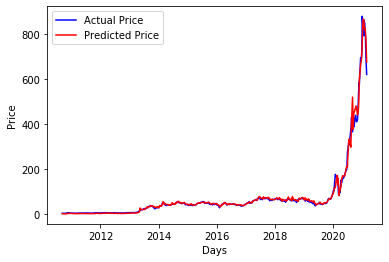

In [120]:
plot_graph(final_df)

In [121]:
print(final_df.tail(10))
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)


                  open        high         low       close    adjclose  \
2020-12-31  699.989990  718.719971  691.119995  705.669983  705.669983   
2021-01-07  777.630005  816.989990  775.200012  816.039978  816.039978   
2021-01-12  831.000000  868.000000  827.340027  849.440002  849.440002   
2021-01-20  858.739990  859.500000  837.280029  850.450012  850.450012   
2021-01-22  834.309998  848.000000  828.619995  846.640015  846.640015   
2021-01-29  830.000000  842.409973  780.099976  793.530029  793.530029   
2021-02-05  845.000000  864.770020  838.969971  852.229980  852.229980   
2021-02-10  843.640015  844.820007  800.020020  804.820007  804.820007   
2021-02-16  818.000000  821.000000  792.440002  796.219971  796.219971   
2021-02-25  726.150024  737.210022  670.580017  682.219971  682.219971   

              volume ticker  adjclose_5  true_adjclose_5  buy_profit  \
2020-12-31  49649900   TSLA  754.039490       880.020020   48.369507   
2021-01-07  51498900   TSLA  836.212891  

In [64]:
import pickle

In [65]:
pickle.dump(model, open('test_model.pkl','wb'))

TypeError: can't pickle _thread.RLock objects

In [ ]:
plt.savefig('saved_figure.png')